In [112]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torch import nn
import pytorch_lightning as L
from pytorch_lightning import seed_everything, LightningModule, Trainer
import numpy as np

In [266]:
train_path = './data/london_weather_energy_train.csv'
valid_path = './data/london_weather_energy_valid.csv'
test_path = './data/london_weather_energy_test.csv'

df_train = pd.read_csv(train_path, parse_dates=['date'], index_col="date")  
df_valid = pd.read_csv(valid_path, parse_dates=['date'], index_col="date")  
df_test = pd.read_csv(test_path, parse_dates=['date'], index_col="date")  

In [267]:
df_train = df_train.drop(columns=['MEAN', 'MIN'])
df_valid = df_valid.drop(columns=['MEAN', 'MIN'])
df_test = df_test.drop(columns=['MEAN', 'MIN'])

In [200]:
df_test.head()

,MAX,snow_False,snow_True,rain_False,rain_True,temp_max_1,temp_max_2,temp_max_3,temp_max_4,temp_min_1,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,21.949,True,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-02,29.753,True,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-03,27.748,True,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-04,33.262,True,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-01-05,34.445,True,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [309]:
scaler = MinMaxScaler()


scaler.fit( df_train[ ['MAX'] ] )

MinMaxScaler()

In [310]:

class WeatherEnergyDataset(Dataset):
    
    def __init__(self, df_data , transformers, window_size=360):

        self.scaler = transformers['max']
        
        self.window_size = window_size
        self.df_data = df_data

        self.data = self.getData()
        
        self.features = self.data
        self.target = self.data.MAX
        
        self.x, self.y = [], []


        # 각 시간간격별 예측시  1일뒤: x = 0 , 2일뒤: x = 1, 3일뒤: x = 2 ...
        #
        # for i in range(len(features) - self.window_size - X):
        #     v = features.iloc[ i: (i + window_size) ].values
        #     self.x.append(v)
        #     self.y.append( target.iloc[ i + window_size + x] )

        
        for i in range(len(self.features) - self.window_size ):
            v = self.features.iloc[ i: (i + self.window_size) ].values
            self.x.append(v)
            self.y.append( self.target[ i + self.window_size ] )



    def getData(self):

        self.df_data.MAX =  self.scaler.transform( self.df_data[['MAX']])

        return self.df_data

    
    def __getitem__(self, index):
        
        x = self.x[index].astype(np.float32)
        y = self.y[index].astype(np.float32)
        return x, y
    
        
        
    
    def __len__(self):
        
        return len(self.x)

In [116]:
os.getcwd()

'/Users/unchil/PythonProjects/timeSerise'

In [311]:
window_size = 360
input_size =29
batch_size=50
learning_rate=0.0001
log_path = '/Users/unchil/PythonProjects/timeSerise/logs/'
device = torch.device("mps") if torch.backends.mps.is_available() else  torch.device("cpu")
NUM_WORKERS = os.cpu_count()
print(f'Device:{device}, Number of workers:{NUM_WORKERS}\nCurrent Dir:{log_path}')

Device:mps, Number of workers:8
Current Dir:/Users/unchil/PythonProjects/timeSerise/logs/


In [312]:
test_data = WeatherEnergyDataset(df_data=df_test,   transformers= { 'max':scaler}, window_size=window_size)

#let's loop it over single iteration and print the shape and also data
for i, (features,targets) in enumerate(test_data):
    print("Size of the features",features.shape)
    print("Printing features:\n", features)
    print("Size of the targets",targets.shape)
    print("Printing targets:\n", targets)
    break
     

Size of the features (360, 29)
Printing features:
 [[-0.26227573  1.          0.         ...  0.          0.
   0.        ]
 [-0.26226908  1.          0.         ...  0.          0.
   0.        ]
 [-0.2622708   1.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.26227084  1.          0.         ...  0.          0.
   1.        ]
 [-0.2622615   1.          0.         ...  0.          0.
   1.        ]
 [-0.2622705   1.          0.         ...  0.          0.
   1.        ]]
Size of the targets ()
Printing targets:
 -0.26227045


/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_2152/244096354.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.y.append( self.target[ i + self.window_size ] )


In [313]:
train_loader = DataLoader( WeatherEnergyDataset(df_data=df_train, transformers= {'max':scaler},), batch_size=batch_size)
valid_loader = DataLoader( WeatherEnergyDataset(df_data=df_valid, transformers= {'max':scaler},), batch_size=batch_size)
test_loader = DataLoader( WeatherEnergyDataset(df_data=df_test,  transformers= {'max':scaler},), batch_size=batch_size)

print(f'train_loader:{len(train_loader)}, valid_loader:{len(valid_loader)}, test_loader:{len(test_loader)}')

train_loader:8, valid_loader:8, test_loader:8


/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_2152/244096354.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.y.append( self.target[ i + self.window_size ] )
/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_2152/244096354.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.y.append( self.target[ i + self.window_size ] )
/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_2152/244096354.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

In [314]:
class WeatherEnergyPrediction(L.LightningModule):
    def __init__(self, input_size=input_size, output_size=1, hidden_dim=10, n_layers=2, lr=learning_rate, window_size=window_size):
 
        super(WeatherEnergyPrediction, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim * window_size, output_size)
        self.loss = nn.MSELoss()
        self.flatten = nn.Flatten()
        self.learning_rate = lr

    

    def forward(self, x):
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)    
        lstm_out, (hidden, cell) = self.lstm(x, hidden)
        out = self.flatten(lstm_out)
        out = self.fc(out)

        return out

    
    
    def init_hidden(self, batch_size):   
        hidden_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        cell_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        hidden = (hidden_state, cell_state)
        return hidden

    
    
    def configure_optimizers(self):
        return {'optimizer': torch.optim.Adam(params=self.parameters(), lr = self.learning_rate) }

    def training_step(self, train_batch, batch_idx):
        features, targets = train_batch
        output = self(features) 
        output = output.view(-1)
        loss = self.loss(output, targets)
        self.log('train_loss', loss, prog_bar=True)
        return {"loss": loss}
        
    
    def validation_step(self, val_batch, batch_idx):
        features, targets = val_batch
        output = self(features) 
        output = output.view(-1)
        loss = self.loss(output, targets)
        self.log('val_loss', loss, prog_bar=True)




In [315]:
model = WeatherEnergyPrediction().to(device)
model

WeatherEnergyPrediction(
  (lstm): LSTM(29, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=3600, out_features=1, bias=True)
  (loss): MSELoss()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [37]:
trainer = L.Trainer( fast_dev_run=True, accelerator='mps', devices=1)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


In [316]:
trainer = L.Trainer( default_root_dir=log_path, max_epochs=100, accelerator='mps', devices=1)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [317]:
trainer.fit( model, train_loader,  valid_loader)


  | Name    | Type    | Params
------------------------------------
0 | lstm    | LSTM    | 2.5 K 
1 | fc      | Linear  | 3.6 K 
2 | loss    | MSELoss | 0     
3 | flatten | Flatten | 0     
------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.024     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [318]:
PATH = '/Users/unchil/PythonProjects/timeSerise/logs/lightning_logs/version_16/checkpoints/epoch=99-step=800.ckpt'
model = WeatherEnergyPrediction.load_from_checkpoint(PATH).to(device)
model.eval()

WeatherEnergyPrediction(
  (lstm): LSTM(29, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=3600, out_features=1, bias=True)
  (loss): MSELoss()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [193]:
test_loader = DataLoader( WeatherEnergyDataset(df_data=df_test,  transformers= {'max':scaler},), batch_size=batch_size)

/var/folders/wp/qtpm72194czff6rn4dry0c7c0000gn/T/ipykernel_2152/171588125.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.y.append( self.target[ i + self.window_size ] )


In [319]:
predicted_result, actual_result = [], []

for i, (features,targets) in enumerate(train_loader):

    features = features.to(device)
    targets = targets.to(device)
    result = model(features)    
    predicted_result.extend(result.view(-1).tolist())
    actual_result.extend(targets.view(-1).tolist())

In [320]:
actual_predicted_df = pd.DataFrame(data={"actual":actual_result, "predicted": predicted_result})
actual_predicted_df

,actual,predicted
0,0.734421,0.375961
1,0.526166,0.379379
2,0.256864,0.374330
3,0.323794,0.366753
4,0.271386,0.366874
...,...,...
366,0.352726,0.343122
367,0.237803,0.343809
368,0.335891,0.347187
369,0.253785,0.358135


In [323]:
actual_predicted_df = pd.DataFrame(data={"actual":actual_result, "predicted": predicted_result})

inverse_transformed_values = scaler.inverse_transform(actual_predicted_df)


actual_predicted_df["actual"] = inverse_transformed_values[:,[0]]
actual_predicted_df["predicted"] = inverse_transformed_values[:,[1]]

actual_predicted_df.index = pd.date_range('2012-12-26', '2013-12-31')

actual_predicted_df

,actual,predicted
2012-12-26,0.734421,0.375961
2012-12-27,0.526166,0.379379
2012-12-28,0.256864,0.374330
2012-12-29,0.323794,0.366753
2012-12-30,0.271386,0.366874
...,...,...
2013-12-27,0.352726,0.343122
2013-12-28,0.237803,0.343809
2013-12-29,0.335891,0.347187
2013-12-30,0.253785,0.358135


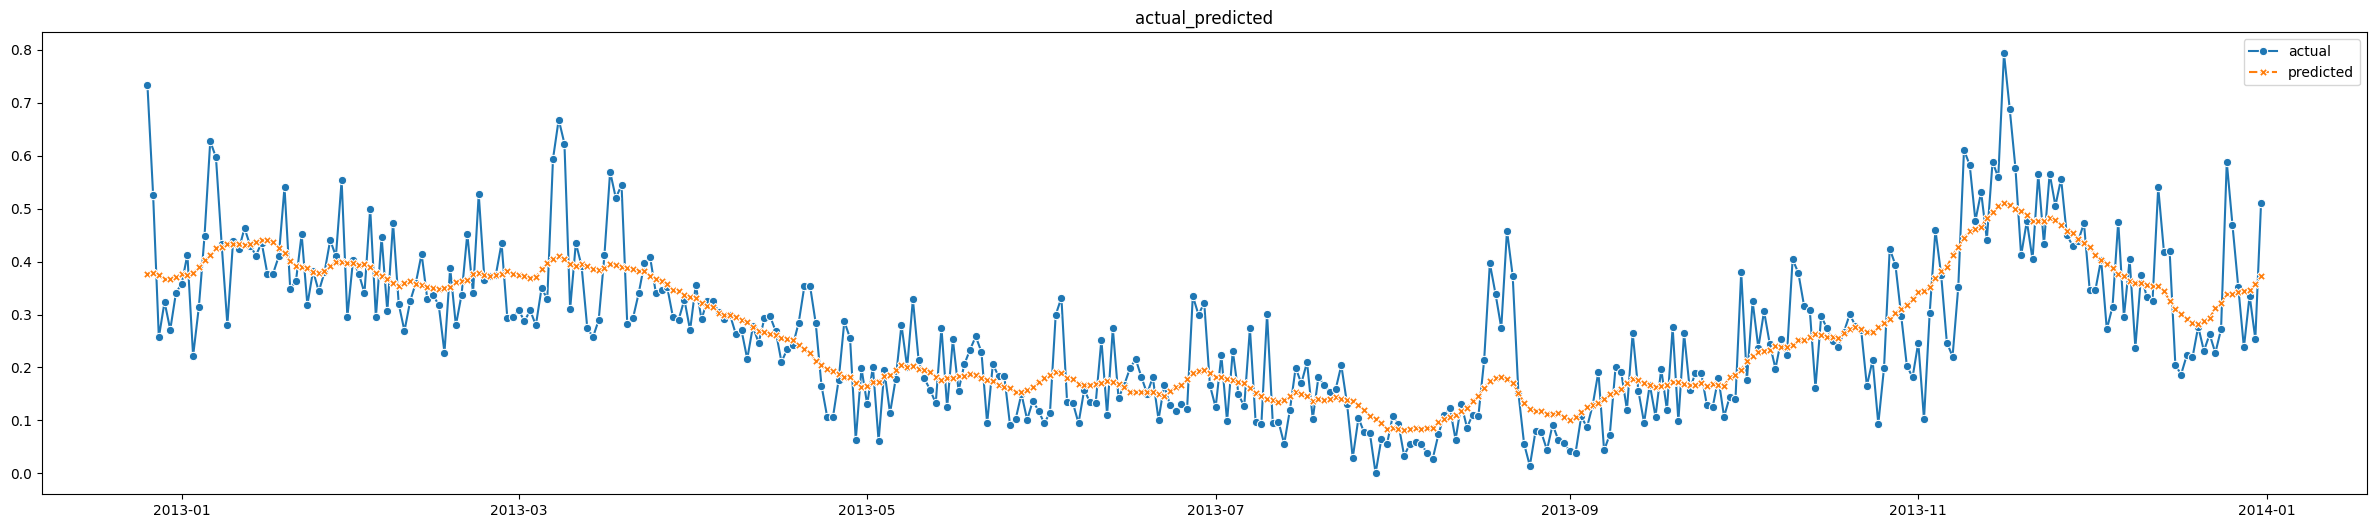

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns


#data = actual_predicted_df.loc['2018-07-20':'2018-07-23']

fig = plt.figure(figsize=(30,6))
axs = fig.subplot_mosaic([['actual_predicted']])
axs['actual_predicted'].set_title('actual_predicted')
sns.lineplot( data = actual_predicted_df['2012-12-26': '2013-12-31'],  markers=True, ax=axs['actual_predicted'] )

plt.show()